In [434]:
import numpy as np
import pylab as plt
import pymzml
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/simon/git/inklda/code/')
from lda import LDA


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
from lda import LDA_Feature_Extractor as LDAF
fe = LDAF(aa_file,use_scans='even')
fe.make_corpus()

Found 1141 documents
Removing 391 words


In [ ]:
from lda import LDA
l = LDA(fe.corpus)

l.gibbs_iteration(100,burn=True)
l.gibbs_iteration(200,burn=False)

Sample 0 of 100 (Burn is True)
Sample 1 of 100 (Burn is True)
Sample 2 of 100 (Burn is True)
Sample 3 of 100 (Burn is True)
Sample 4 of 100 (Burn is True)
Sample 5 of 100 (Burn is True)
Sample 6 of 100 (Burn is True)
Sample 7 of 100 (Burn is True)
Sample 8 of 100 (Burn is True)
Sample 9 of 100 (Burn is True)
Sample 10 of 100 (Burn is True)
Sample 11 of 100 (Burn is True)
Sample 12 of 100 (Burn is True)
Sample 13 of 100 (Burn is True)
Sample 14 of 100 (Burn is True)
Sample 15 of 100 (Burn is True)
Sample 16 of 100 (Burn is True)
Sample 17 of 100 (Burn is True)
Sample 18 of 100 (Burn is True)
Sample 19 of 100 (Burn is True)
Sample 20 of 100 (Burn is True)
Sample 21 of 100 (Burn is True)
Sample 22 of 100 (Burn is True)
Sample 23 of 100 (Burn is True)
Sample 24 of 100 (Burn is True)
Sample 25 of 100 (Burn is True)
Sample 26 of 100 (Burn is True)
Sample 27 of 100 (Burn is True)
Sample 28 of 100 (Burn is True)
Sample 29 of 100 (Burn is True)
Sample 30 of 100 (Burn is True)
Sample 31 of 100 (

In [391]:
from ink_functions import ImagingGrid
ig = ImagingGrid()

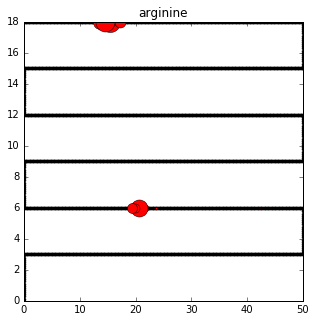

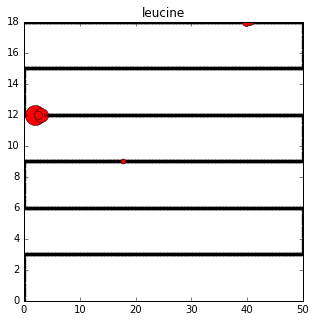

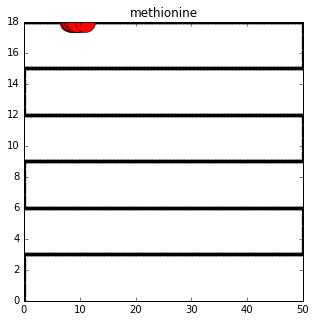

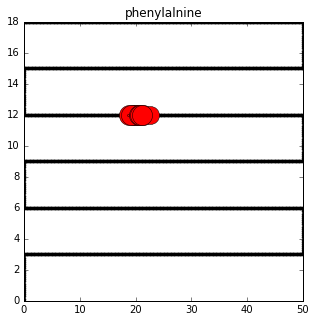

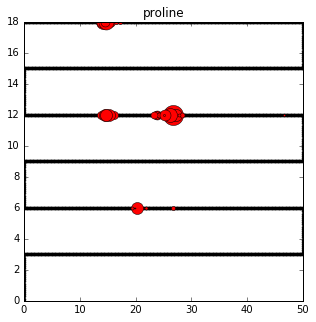

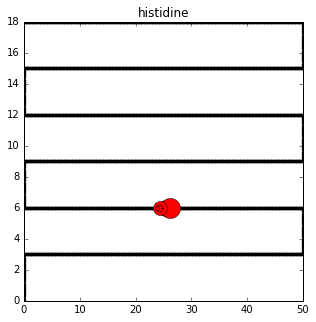

In [392]:
amino_acids = {'histidine':156.0678,'arginine':175.1190,'proline':116.0706,
               'phenylalnine':166.0683,'leucine':132.1019,'methionine':150.0583}
# Check with the amino acids
for a in amino_acids:
    intensity_vector = {}
    w = fe.word_names[np.abs(amino_acids[a] - np.array(fe.word_masses)).argmin()]
    for doc in fe.corpus:
        if w in fe.corpus[doc]:
            intensity_vector[doc] = fe.corpus[doc][w]
    ig.plot(vals=intensity_vector,figsize=(5,5),max_marker_size=20)
    plt.title(a)

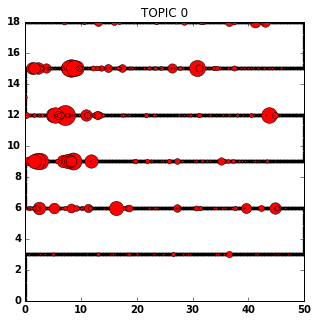

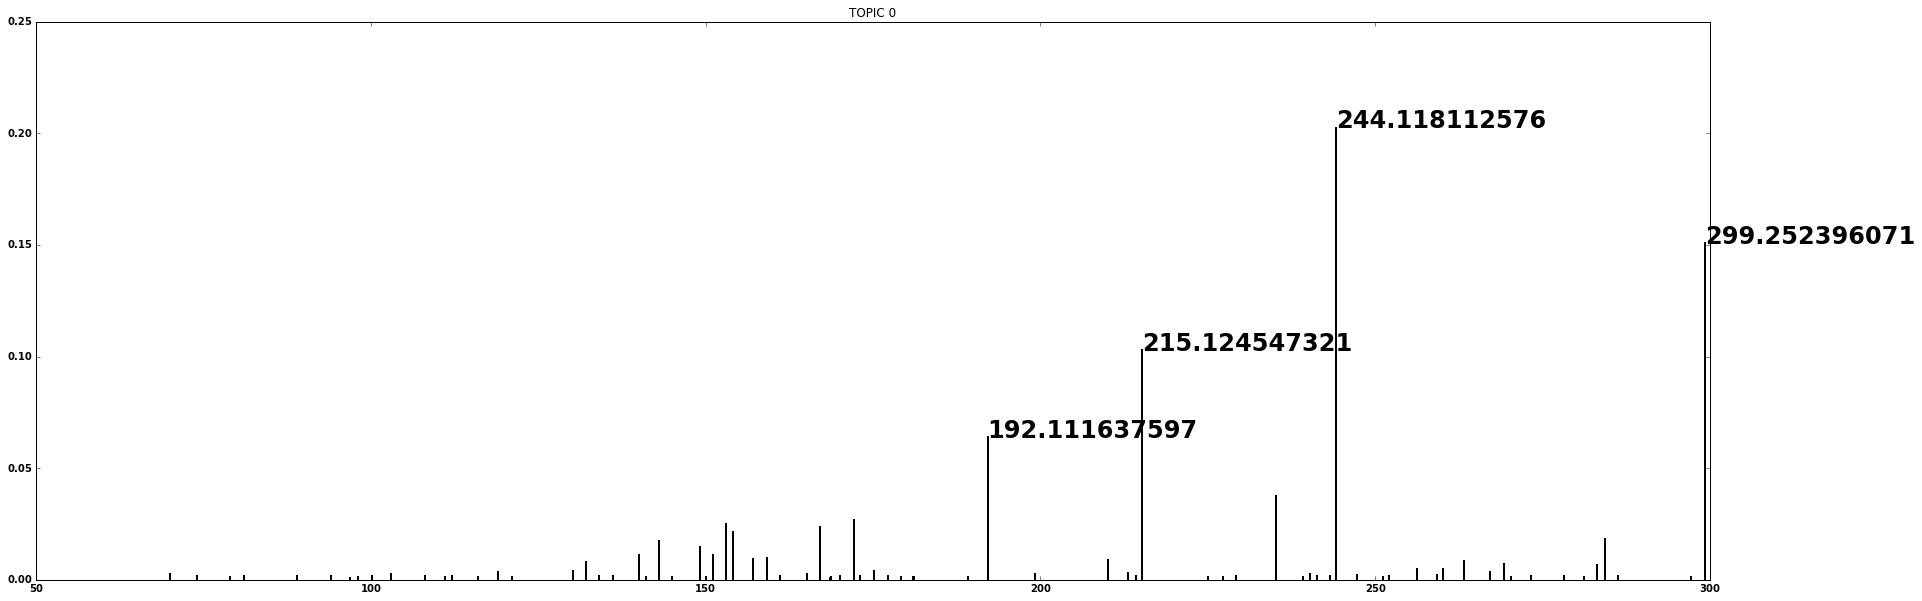

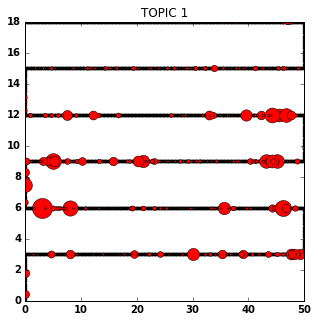

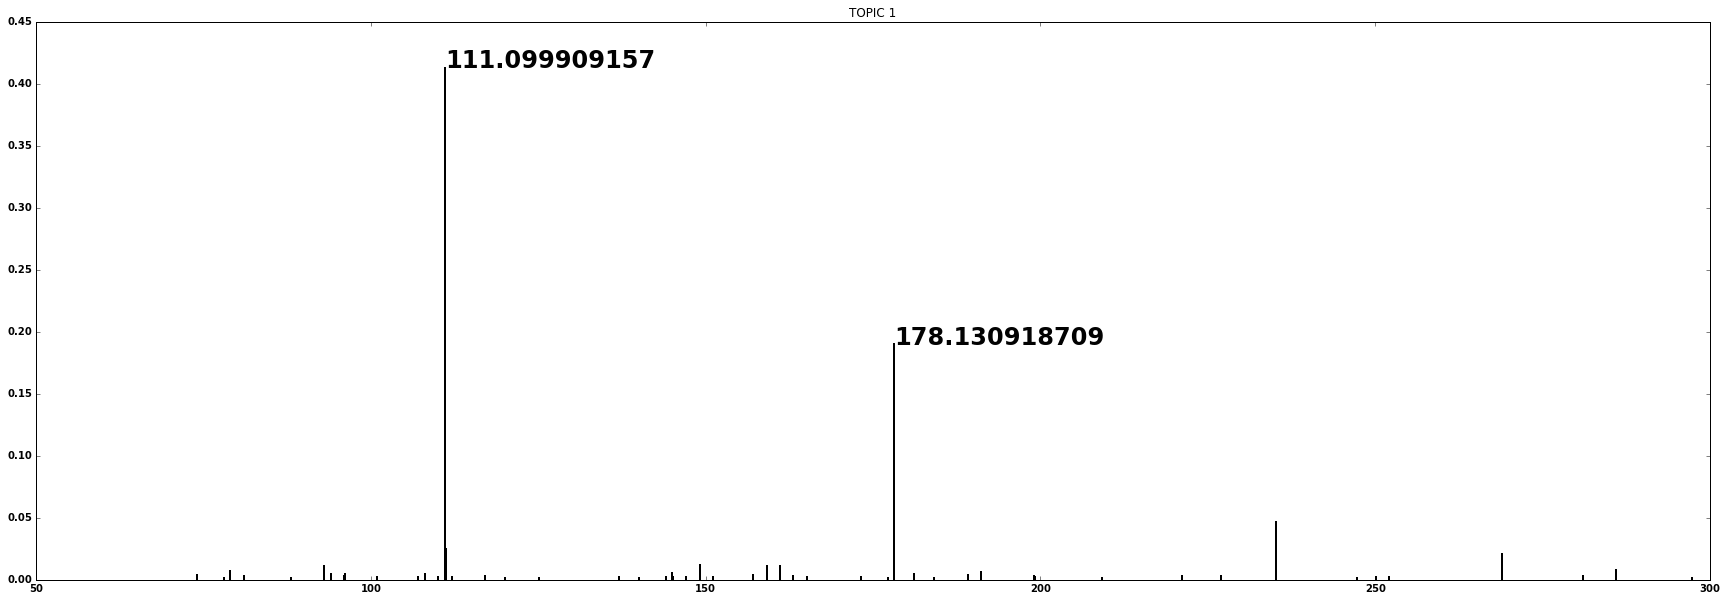

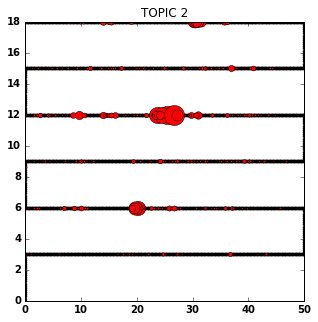

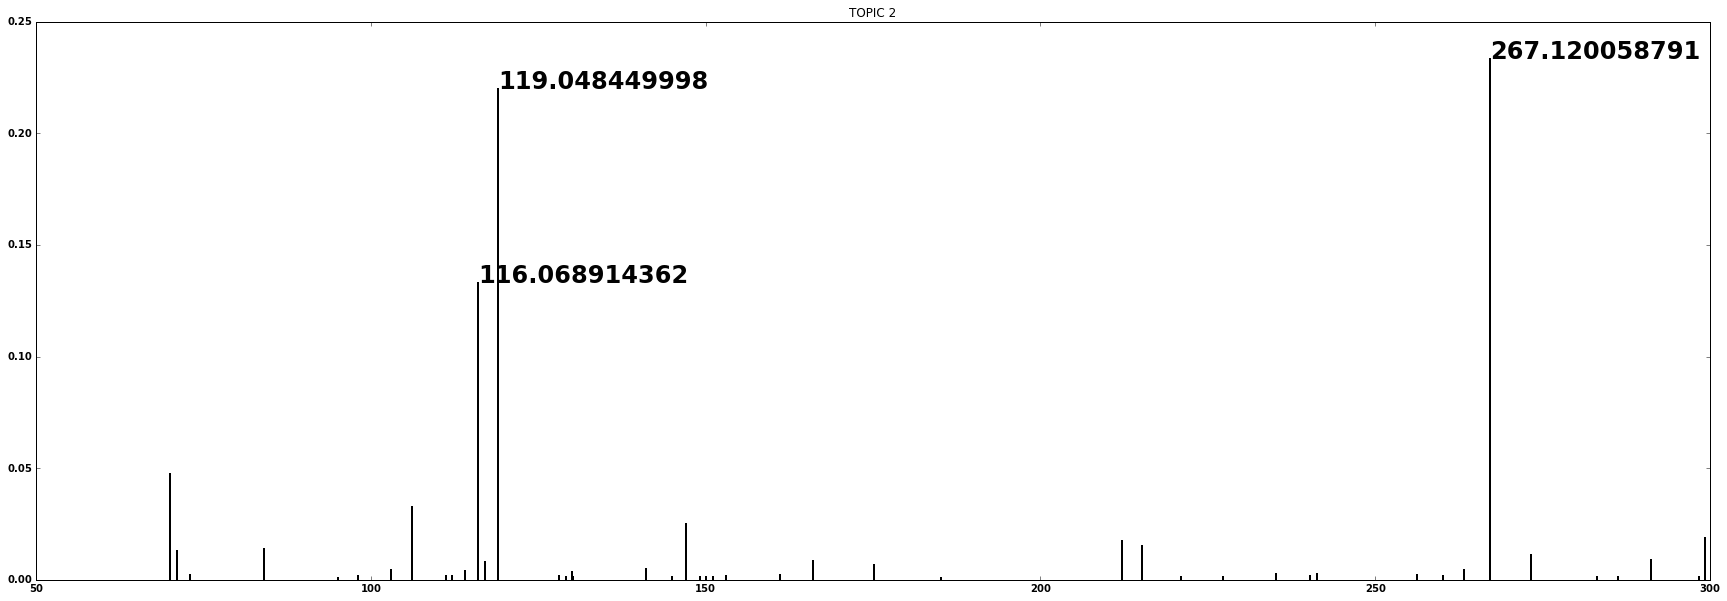

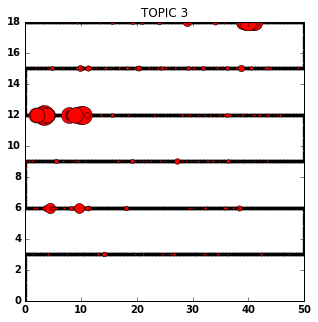

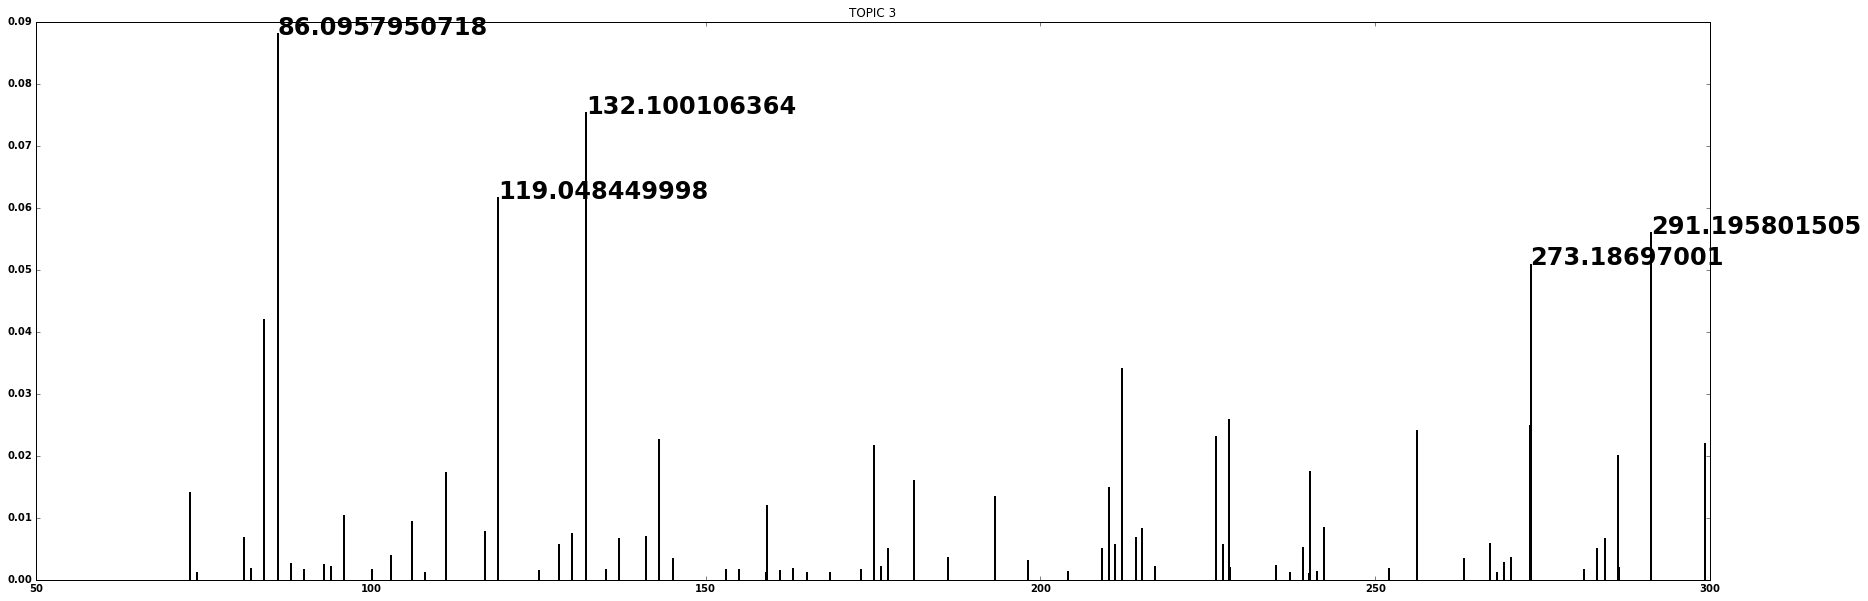

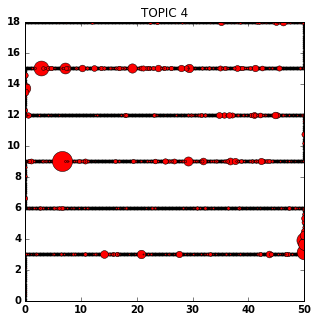

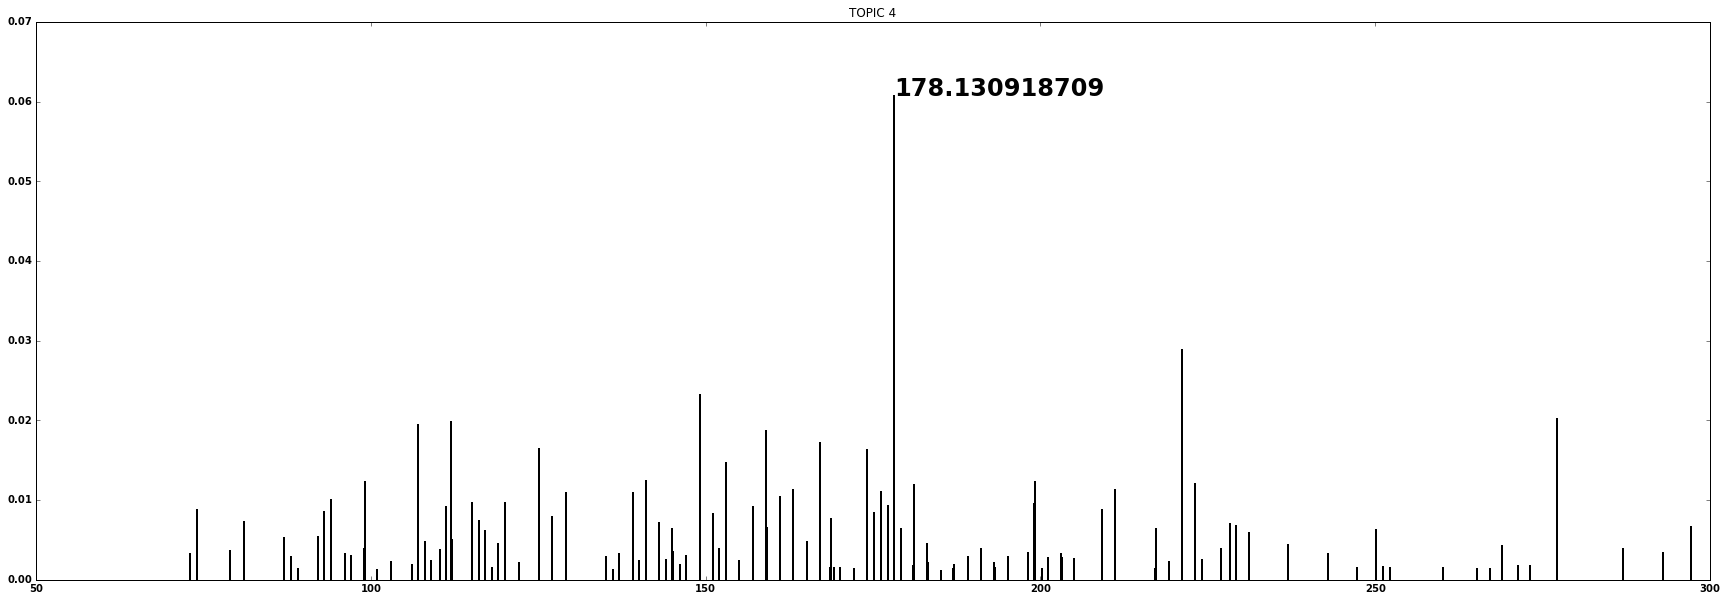

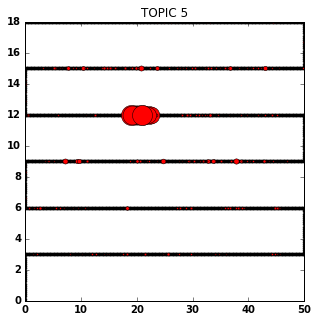

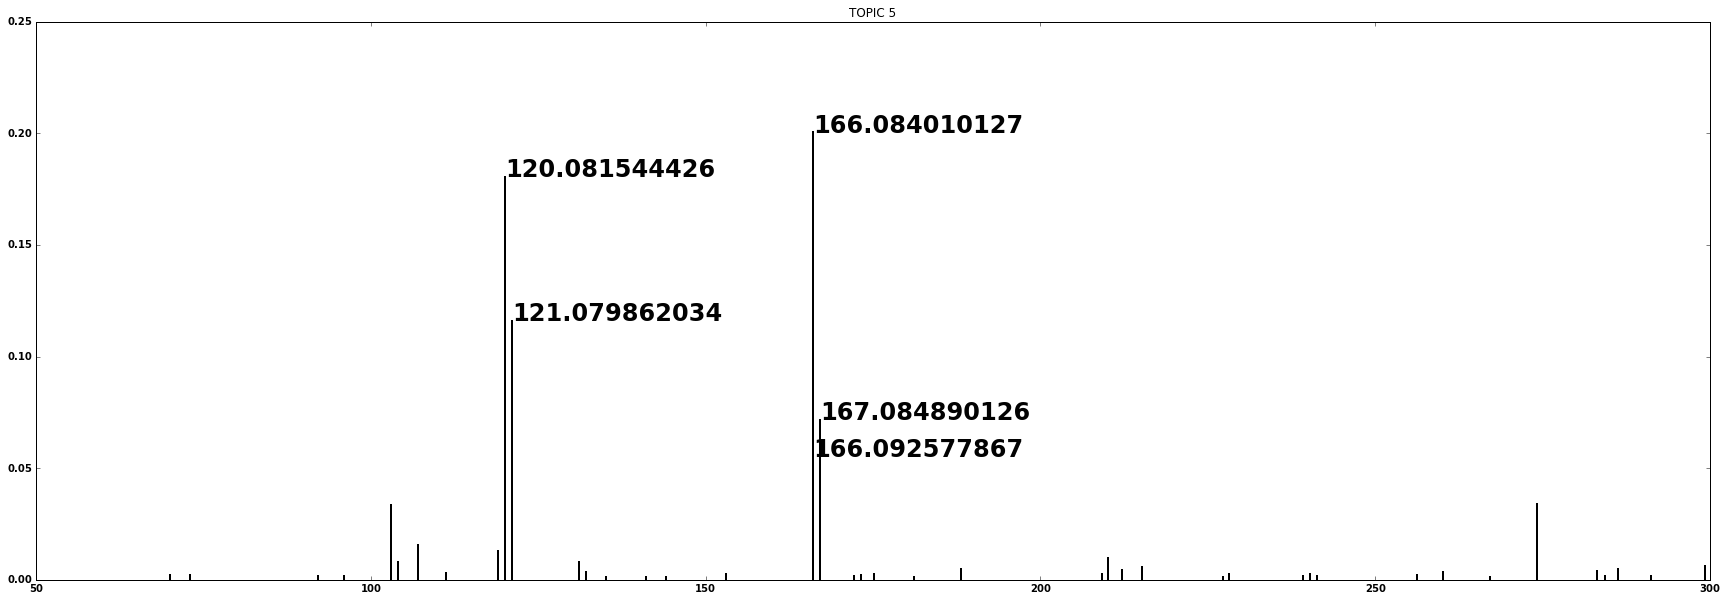

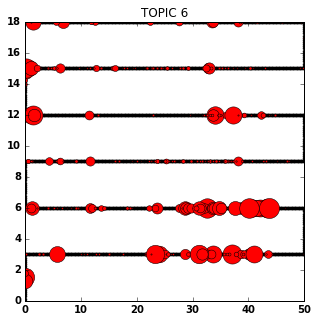

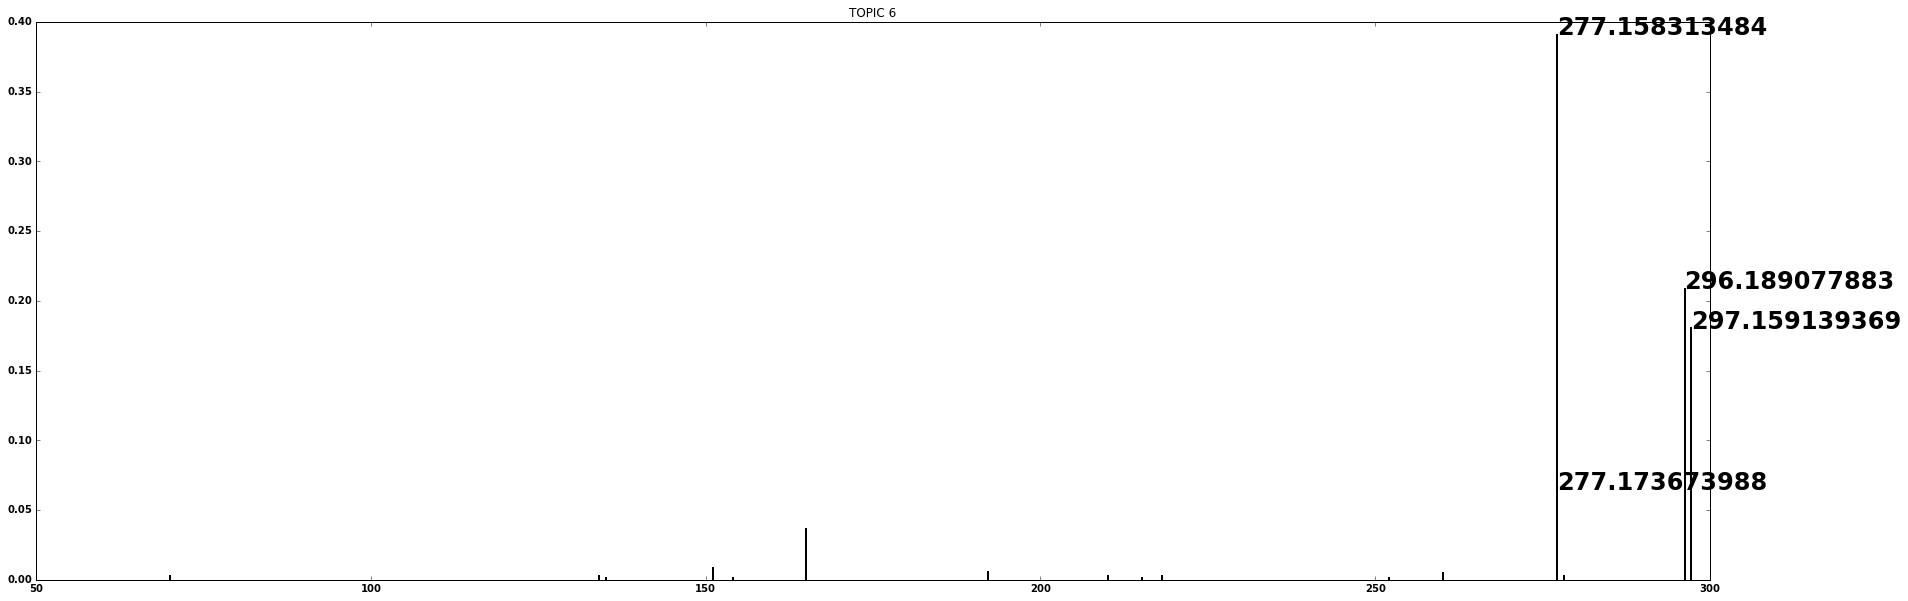

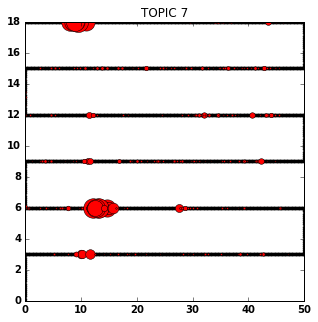

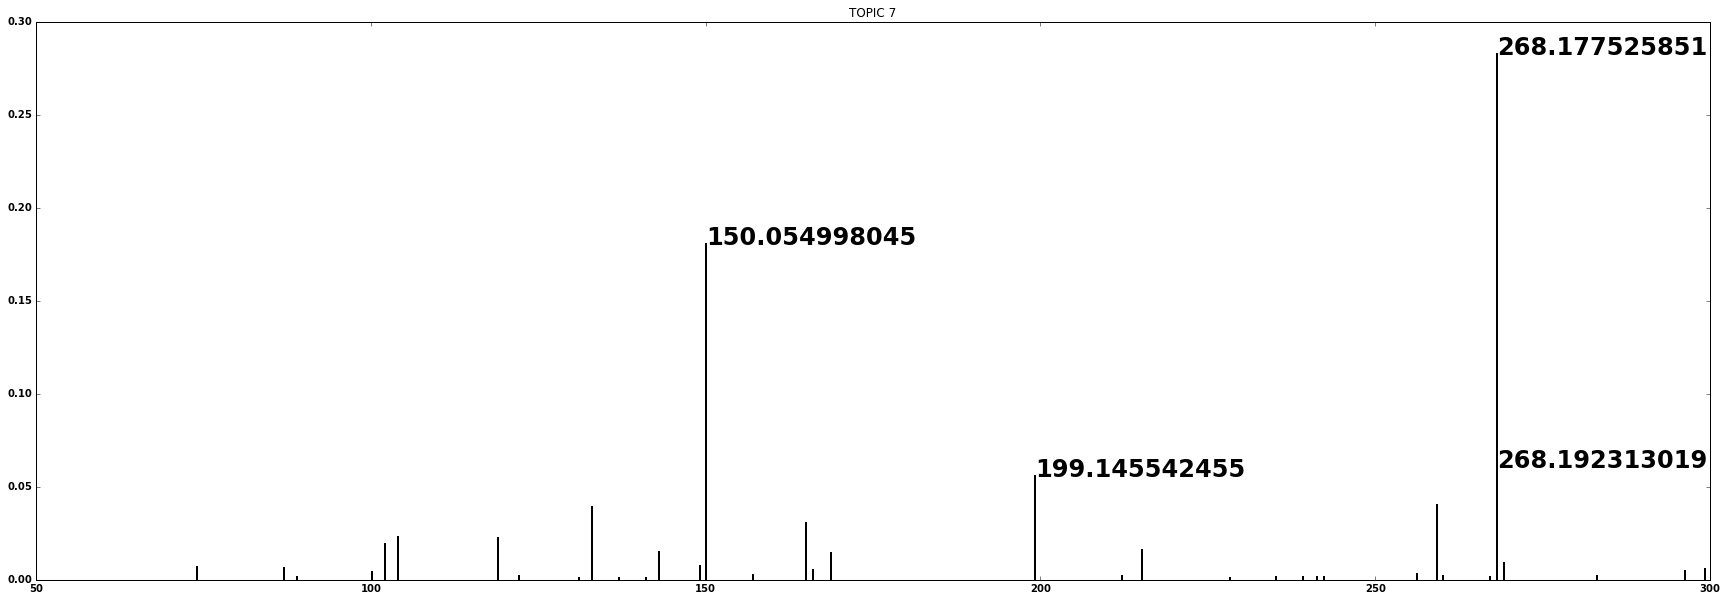

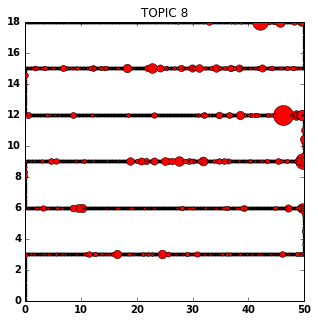

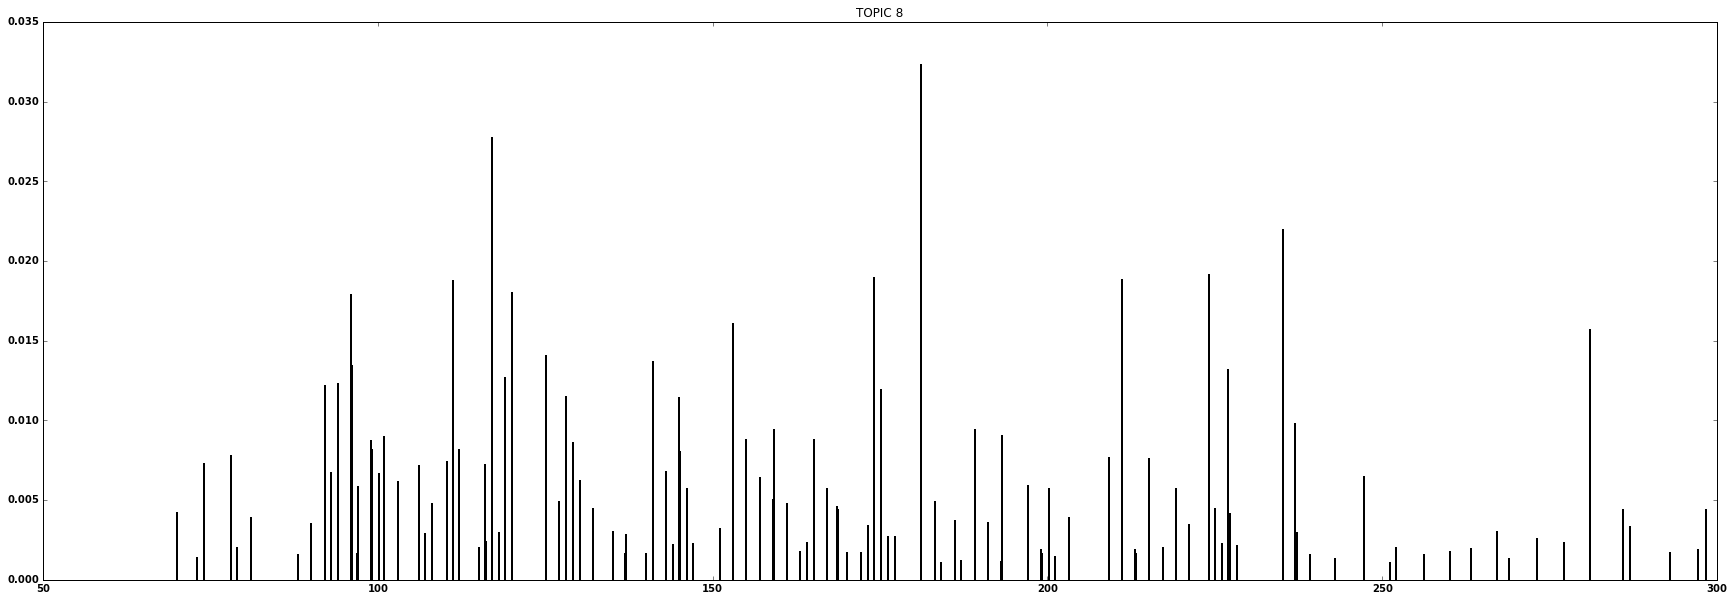

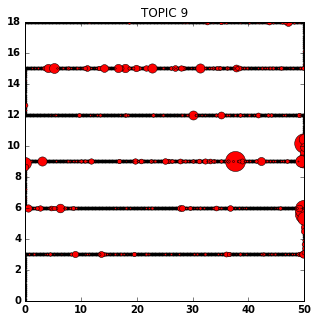

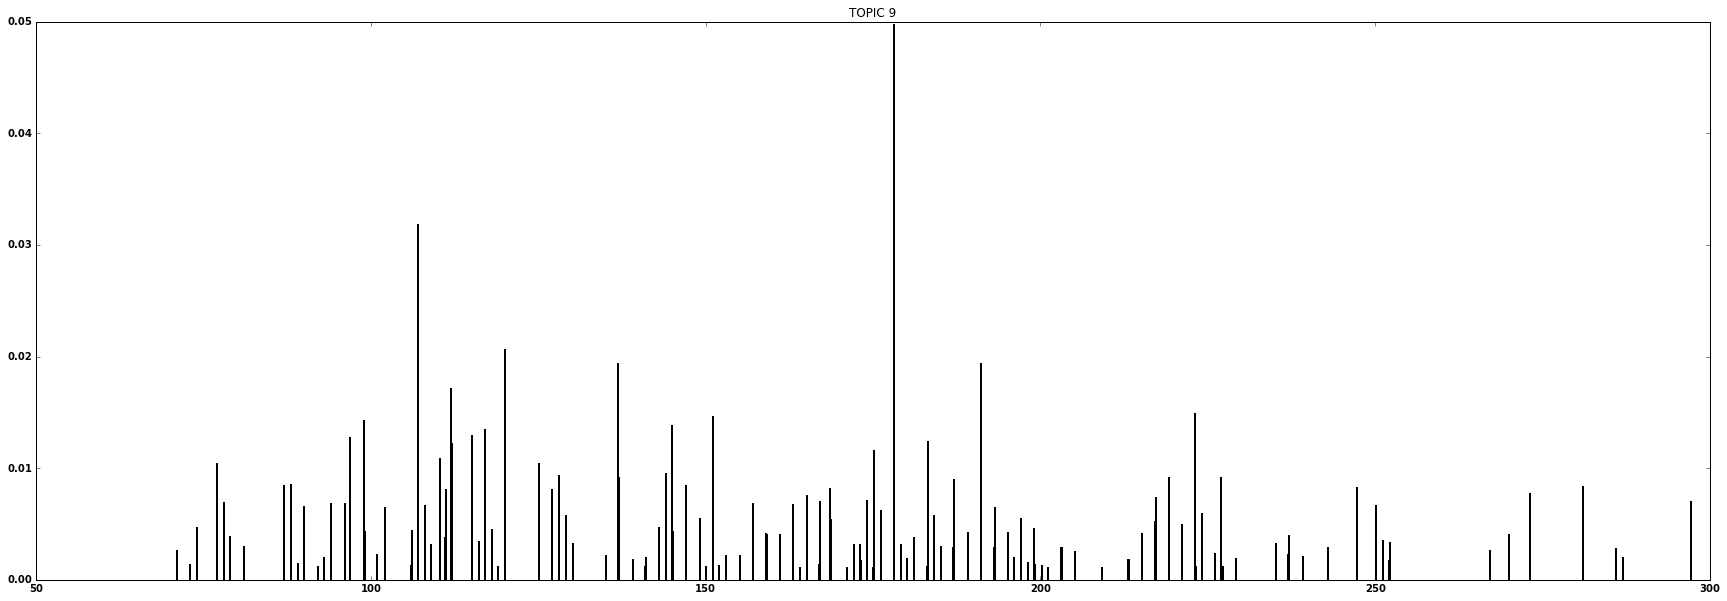

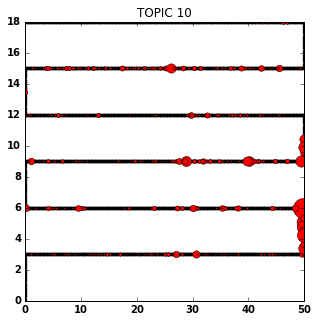

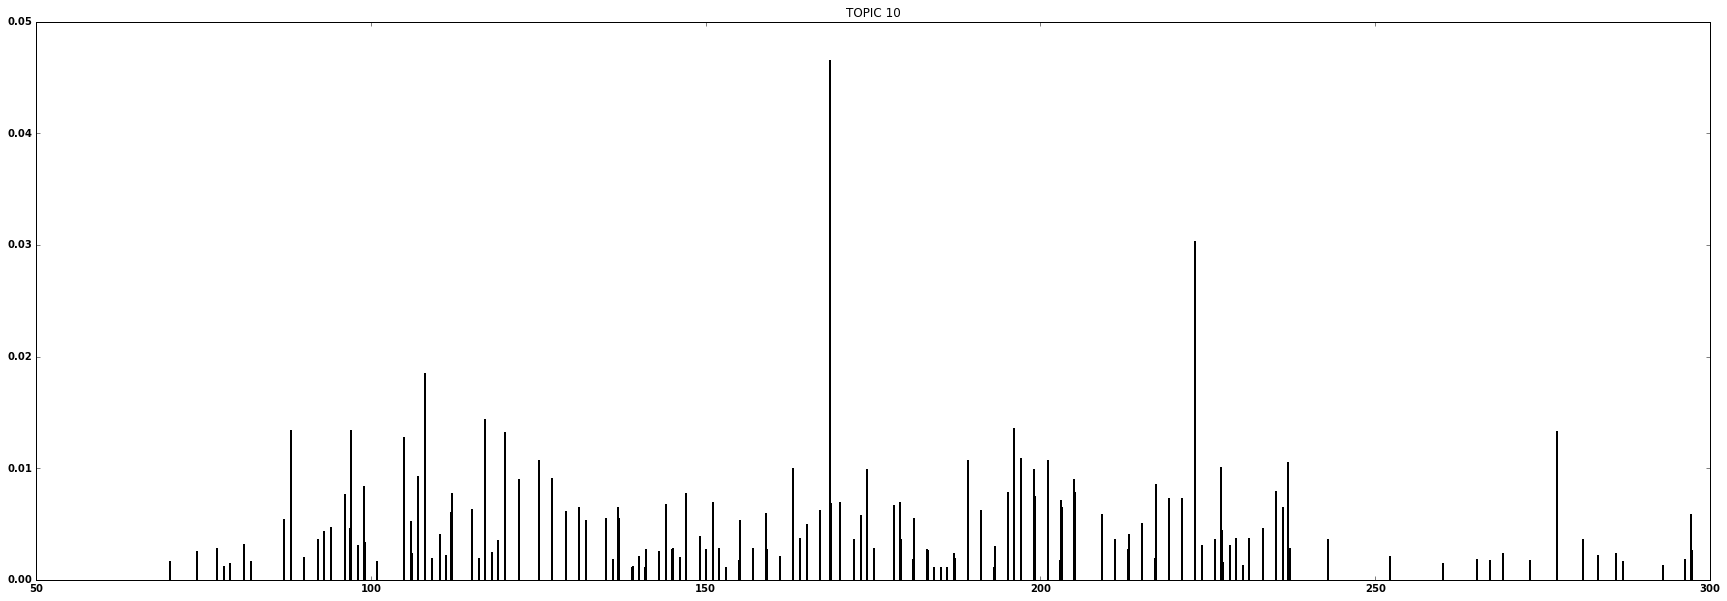

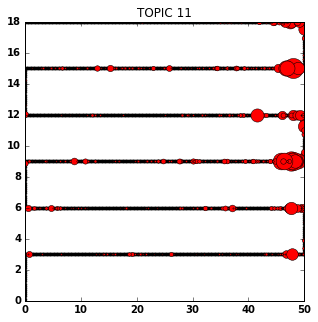

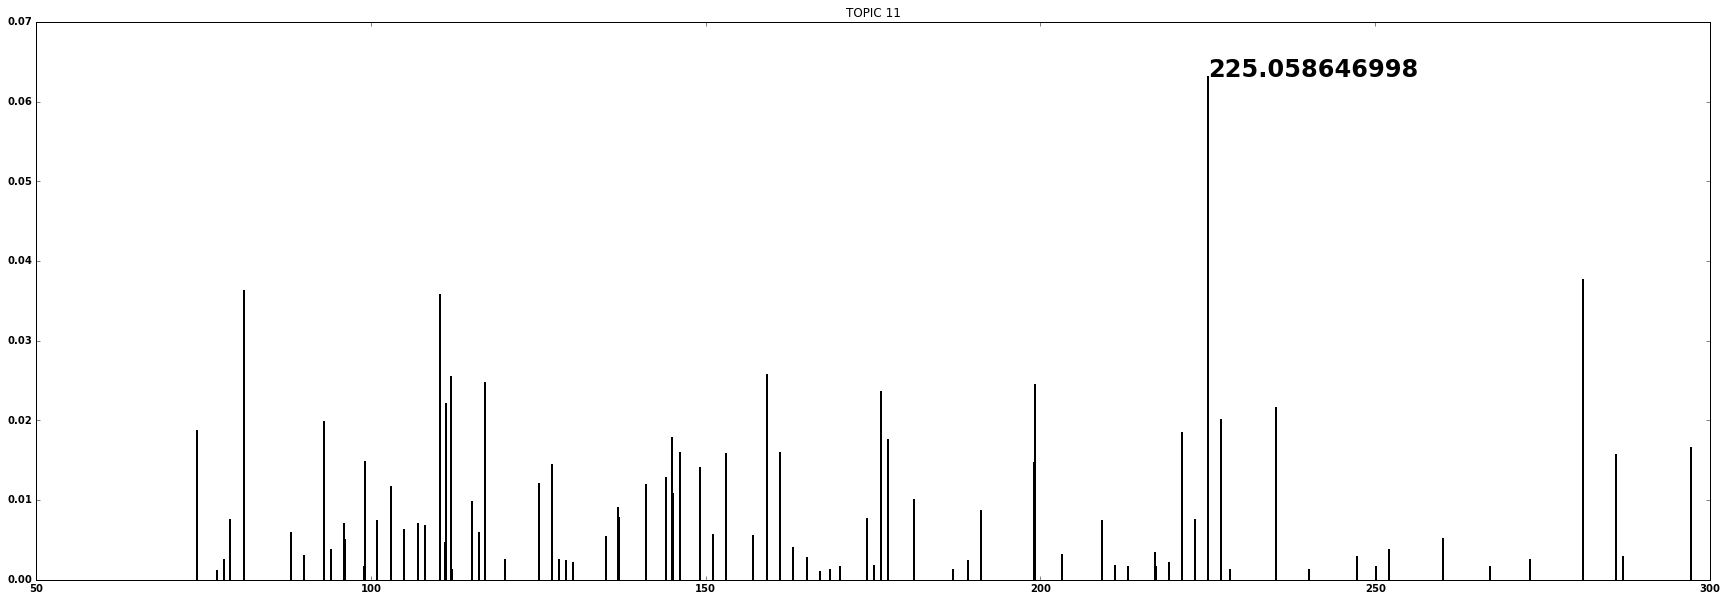

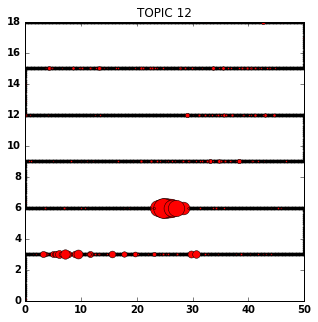

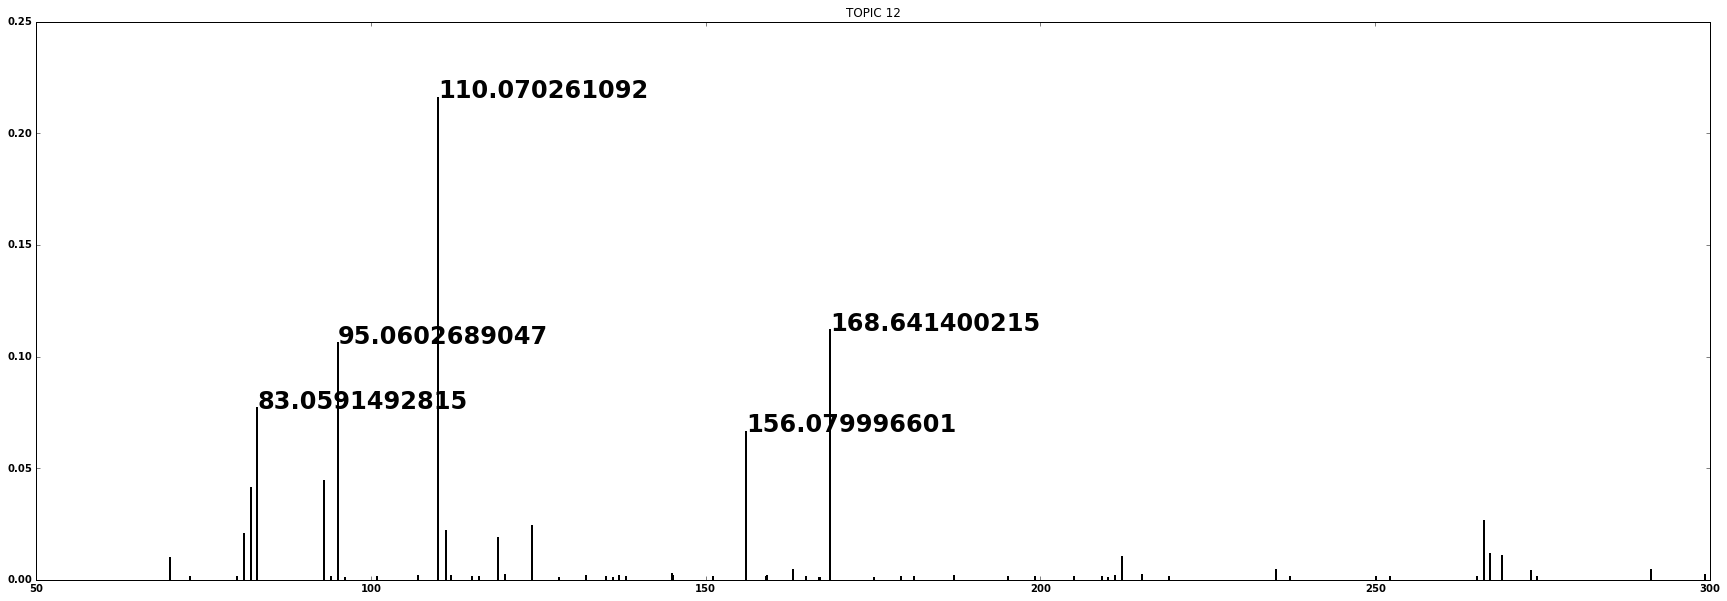

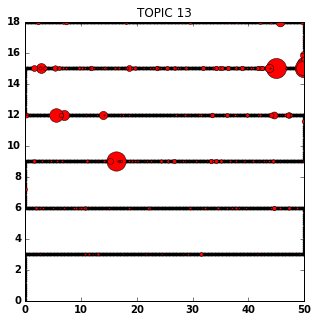

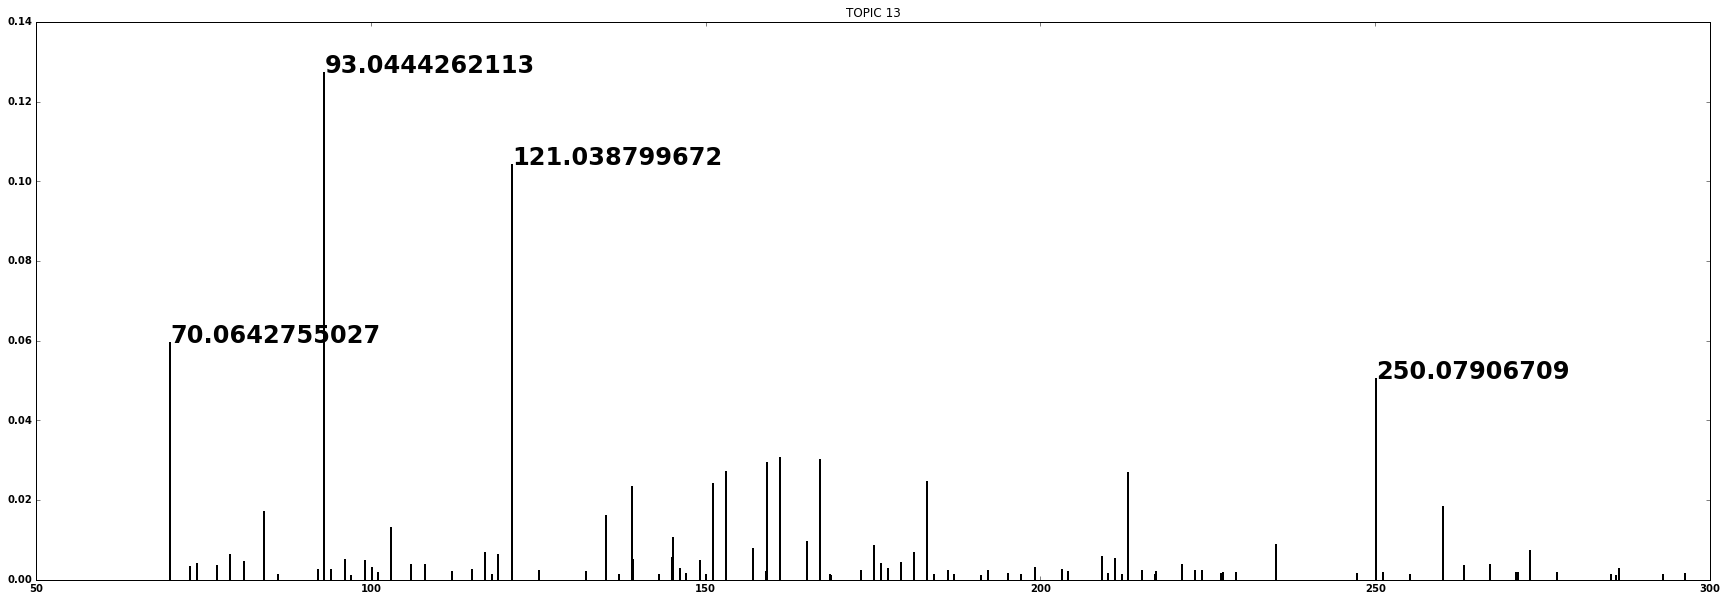

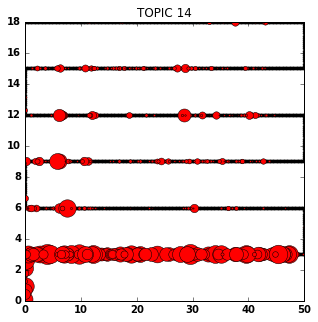

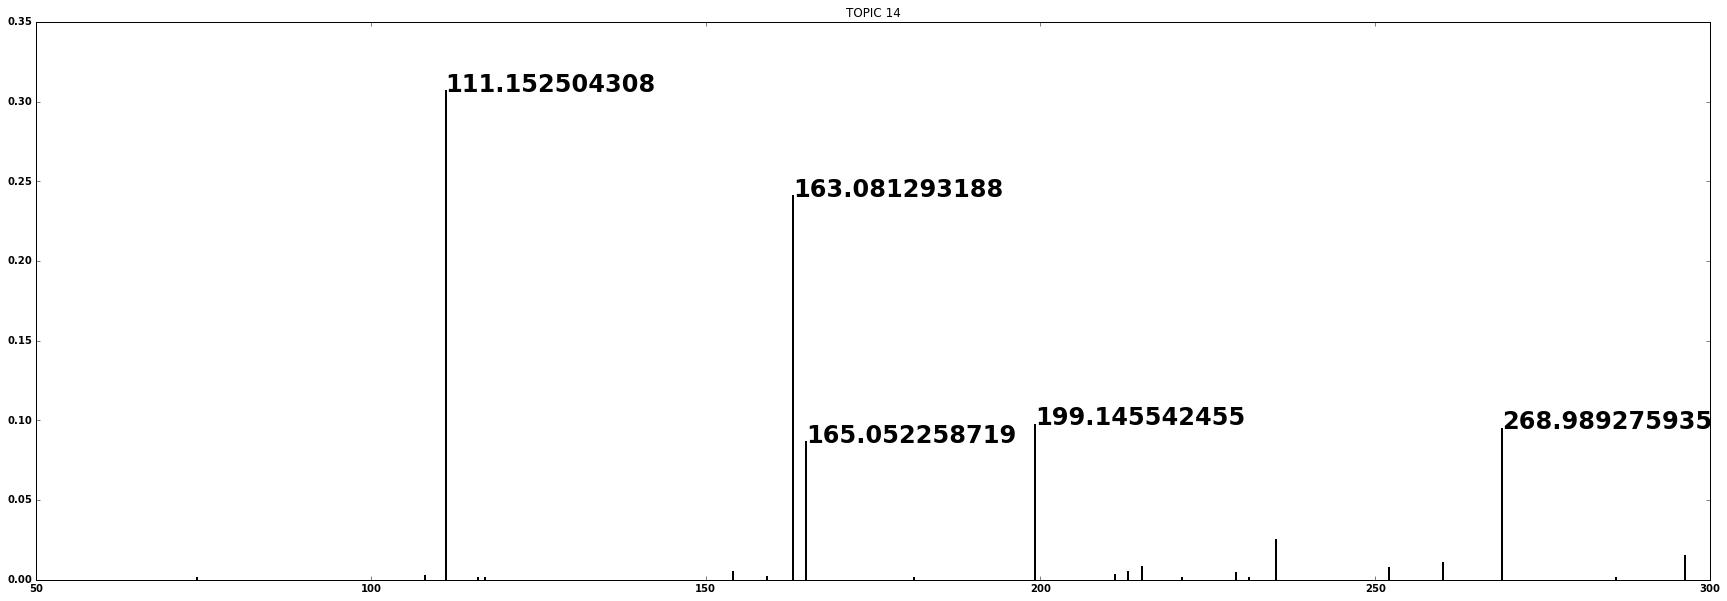

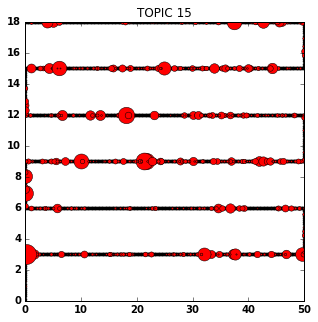

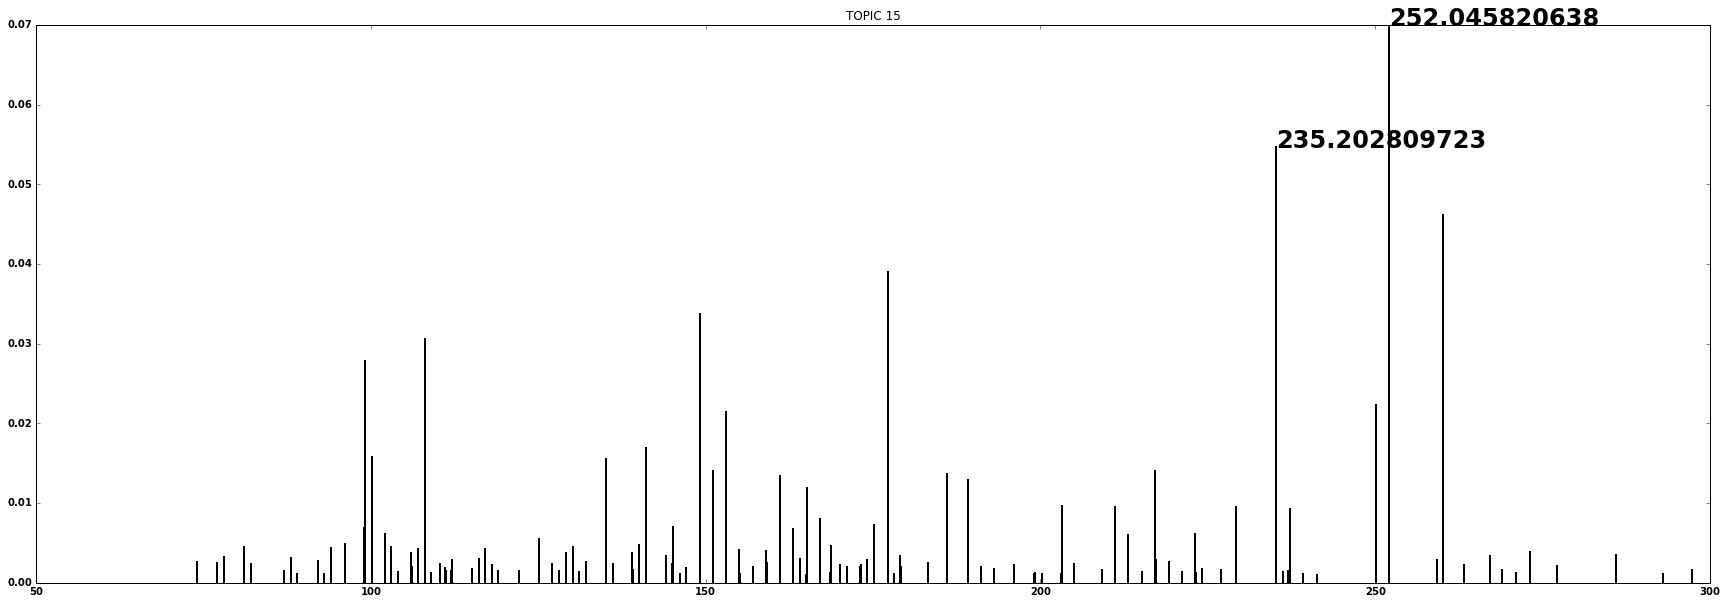

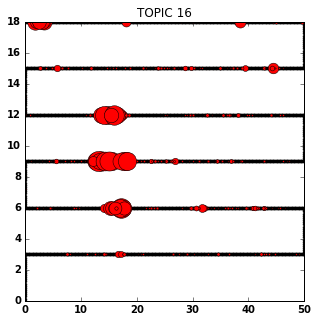

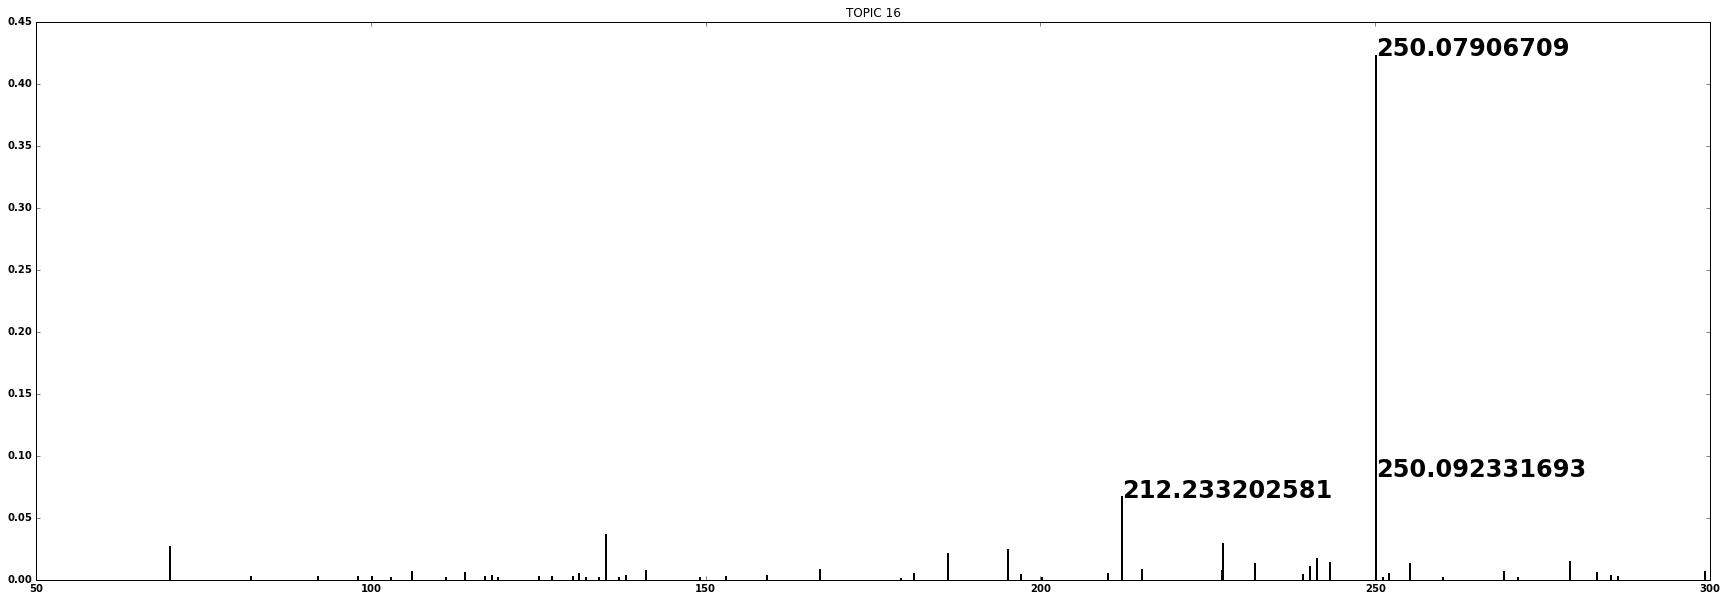

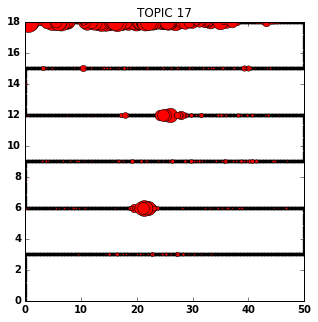

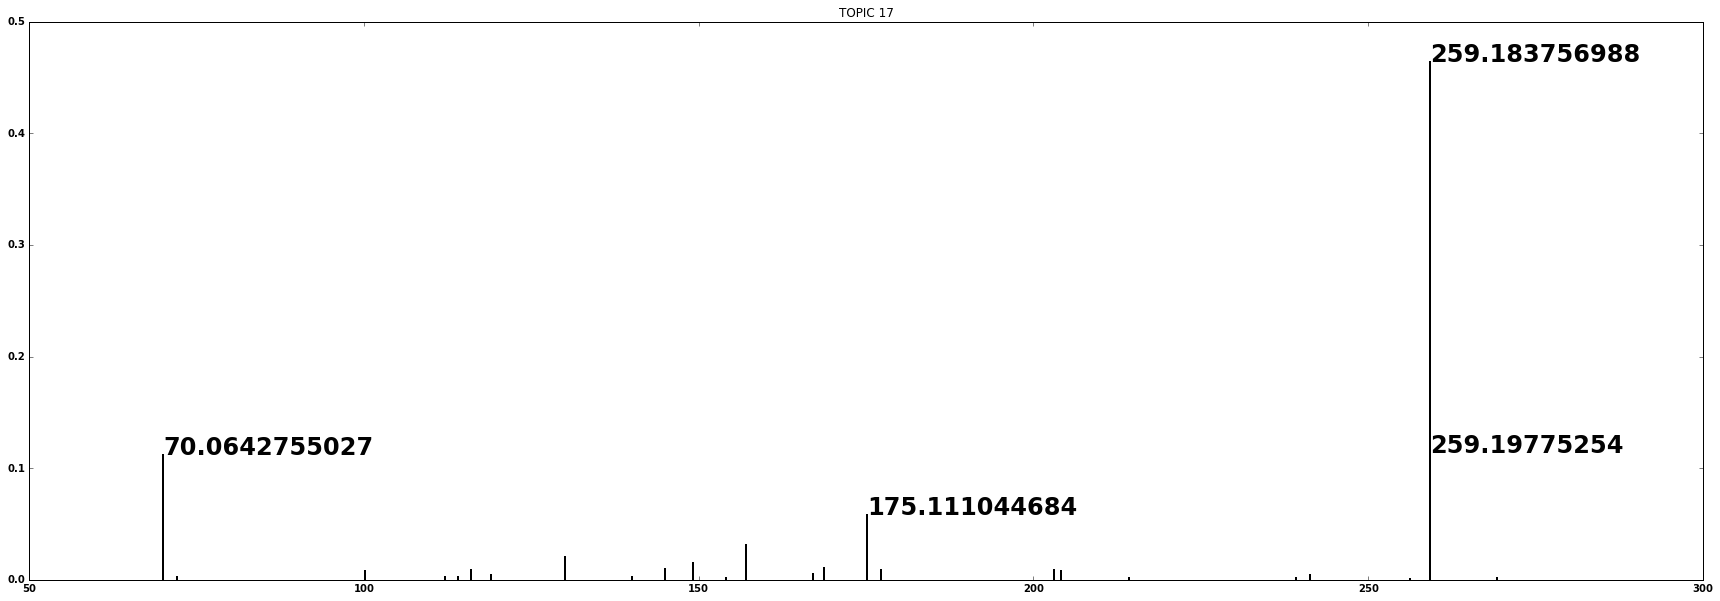

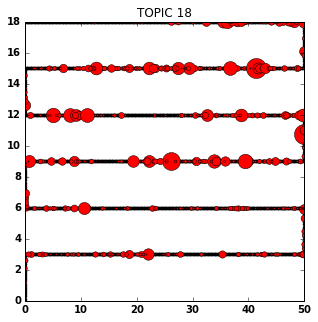

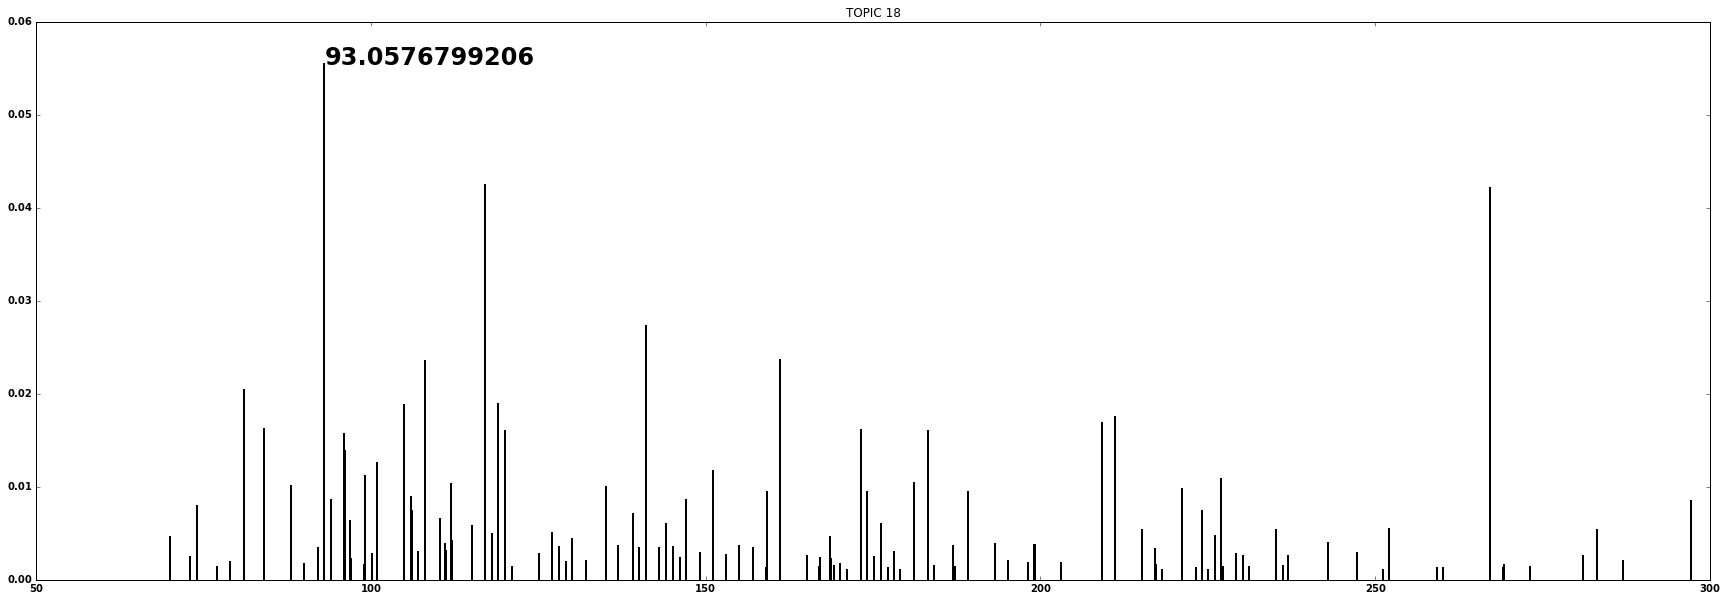

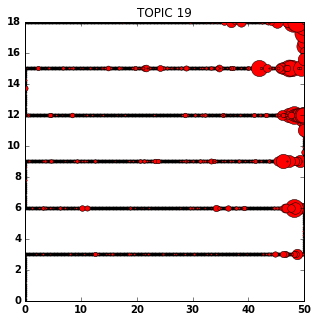

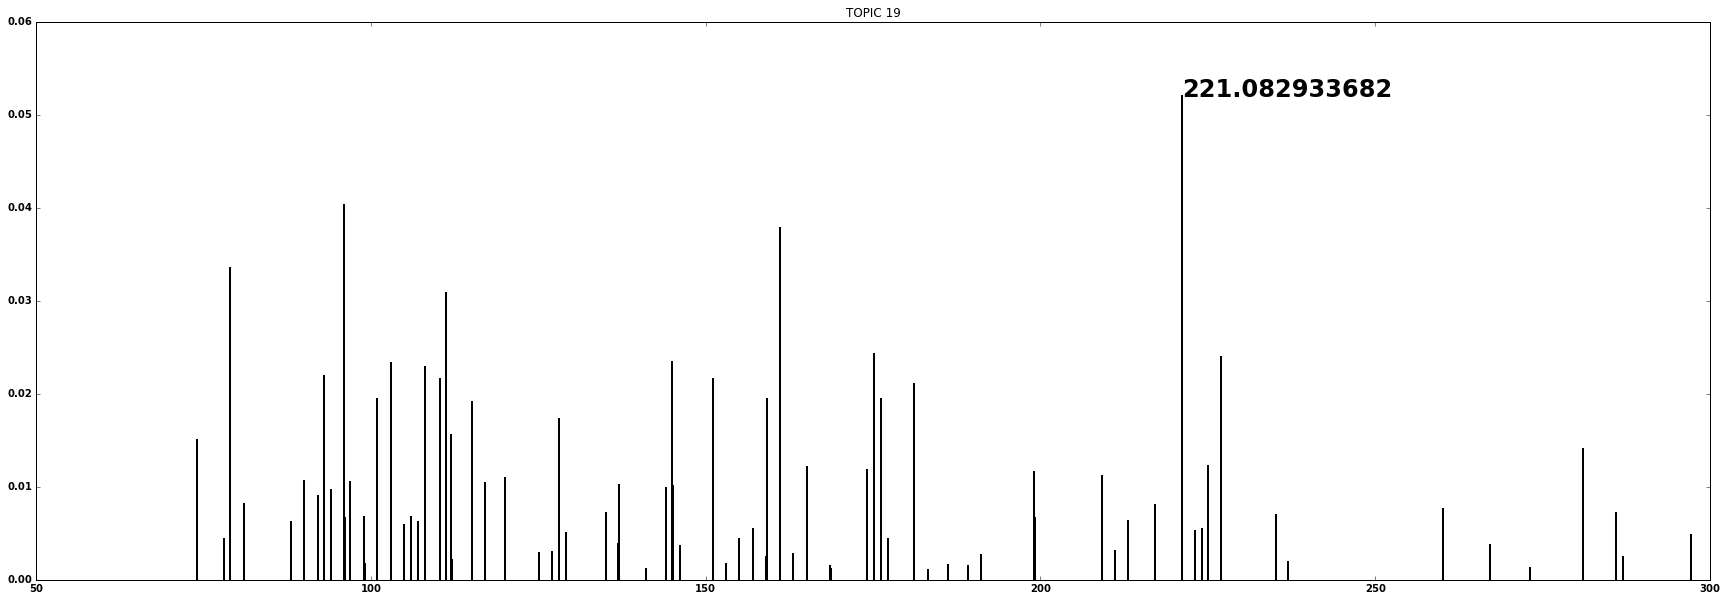

In [440]:
from ink_functions import plot_topic_dict
for topic_of_interest in range(l.K):
#     print
#     print
#     print "TOPIC {}".format(topic_of_interest)
    ig.plot(vals=l.get_topic_as_doc_dict(topic_of_interest),figsize=(5,5),max_marker_size=20)
    plt.title('TOPIC {}'.format(topic_of_interest))
    plot_topic_dict(l.get_topic_as_dict(topic_of_interest))
    plt.title('TOPIC {}'.format(topic_of_interest))
    
#     top = l.get_topic_as_tuples(topic_of_interest,thresh=0.01)
#     for t in top:
#         print t[0],t[1]

In [437]:

for a in amino_acids:
    interest_word = word_names[np.abs(word_masses - amino_acids[a]).argmin()]
    print interest_word
    interest_index = l.word_index[interest_word]
    print l.topic_word_counts[:,interest_index]
    best_topic = l.topic_word_counts[:,interest_index].argmax()
    print "{} best topic: {}".format(a,best_topic)

In [367]:
def make_image(intense,rowcoord,colcoord,x_start = 0,x_end = 50,x_step=1,y_start=0,y_end=18,y_step=3):
    x_lower_vals = np.arange(x_start,x_end,x_step)
    y_lower_vals = np.arange(y_start,y_end,y_step)

    n_x = len(x_lower_vals)
    n_y = len(y_lower_vals)

    image = np.zeros((n_y,n_x),np.float)

    for k,yc in enumerate(rowcoord):
        if yc > y_lower_vals[-1]:
            y_in = n_y-1
        elif yc == y_lower_vals[0]:
            y_in = y_lower_vals[0]
        else:
            y_in = np.where(yc > y_lower_vals)[0][-1]
        xc = colcoord[k]
        if xc > x_lower_vals[-1]:
            x_in = n_x - 1
        elif xc == x_lower_vals[0]:
            x_in = x_lower_vals[0]
        else:
            x_in = np.where(xc > x_lower_vals)[0][-1]
        image[n_y-y_in-1,x_in] += intense[k]
    return image

In [7]:
def hit(m1,m2,tol):
    if 1e6*abs(m1-m2)/m1 < tol:
        return True
    else:
        return False